# Getting the embeddings

> This notebook gets the embeddings (or latent space) from a multivariate time series 
given by a encoder (e.g., autoencoder).

In [1]:
model_patch_size = 8
verbose          = 0
reset_kernel     = False

In [2]:
from dvats.all import *
from tsai.data.preparation import SlidingWindow
from fastcore.all import *
import wandb
wandb_api = wandb.Api()
from yaml import load, FullLoader
import dvats.utils as ut

/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(



Octave is ready <oct2py.core.Oct2Py object at 0x7f25012d41f0>

















In [3]:
import torch
torch.cuda.set_device(0)

## Config parameters
> Configuration parameters are obtained from 'config\03-embeddings.yaml'

### Get configuration artifact

In [4]:
config, job_type = get_artifact_config_embeddings(verbose = 0)

In [5]:
dvats.config.show_attrdict(config)

use_wandb: True
wandb_group: embeddings
wandb_entity: mi-santamaria
wandb_project: deepvats
enc_artifact: mi-santamaria/deepvats/mvp:latest
input_ar: None
cpu: False


### Show configuration artifact

In [6]:
for key, value in config.items():
    print(f"{key}: {value}")

use_wandb: True
wandb_group: embeddings
wandb_entity: mi-santamaria
wandb_project: deepvats
enc_artifact: mi-santamaria/deepvats/mvp:latest
input_ar: None
cpu: False


## Build W&B artifact

In [7]:
import os
path = os.path.expanduser("~/work/nbs_pipeline/")
name="03a_embeddings"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
print("runname: "+runname)

runname: 03a_embeddings


In [8]:
run = wandb.init(
    entity      = config.wandb_entity,
    project     = config.wandb_project if config.use_wandb else 'work-nbs', 
    group       = config.wandb_group,
    job_type    = job_type,
    mode        = 'online' if config.use_wandb else 'disabled',
    anonymous   = 'never'  if config.use_wandb else 'must',
    config      = config,
    resume      = 'allow',
    name        = runname
)

wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


## Get trained model artifact

### Build artifact selector
> Botch to use artifacts offline

In [9]:
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

### Get the model from W&B
> Restore the encoder model and its associated configuration

In [10]:
enc_artifact = artifacts_gettr(config.enc_artifact, type='learner')

In [11]:
# TODO: This only works when you run it two timeS! WTF?
try:
    enc_learner = enc_artifact.to_obj()
except:
    enc_learner = enc_artifact.to_obj()

wandb:   1 of 1 files downloaded.  


## Get dataset artifact from W&B
### Restore the dataset artifact used for training the encoder. 
> Even if we do not compute the dimensionality reduction over this dataset, we need to know the metadata of the encoder training set, to check that it matches with the dataset that we want to reduce.

In [12]:
enc_run            = enc_artifact.logged_by()
enc_artifact_train = artifacts_gettr(
                        enc_run.config['train_artifact'], 
                        type='dataset'
                    )
enc_artifact_train.name

'gtrends_khols-normalized_yearly:v0'

In [13]:
dvats.config.show_attrdict(enc_run.config)

r: 0.4
w: 17
MVP: {'r': 0.4, 'lm': 3, 'crit': None, 'sync': False, 'fname': 'encoder_MVP', 'dropout': 0.1, 'verbose': False, 'stateful': False, 'save_best': True, 'nan_to_num': 0, 'custom_mask': None, 'future_mask': True, 'weights_path': None, 'variable_mask': False, 'subsequence_mask': True}
alias: gtrends_khols-normalized_yearly
n_inp: 1
device: cuda
epochs: 200
frozen: False
mvp_ws: [12, 17]
stride: 1
Learner: {'lr': 0.001, 'wd': None, 'arch': 'tsai.models.InceptionTimePlus.InceptionTimePlus', 'moms': [0.95, 0.85, 0.95], 'path': '.', '_name': '<fastai.learner.Learner object at 0x7f811e636110>', 'metrics': None, 'opt_func': 'fastai.optimizer.Adam', 'splitter': 'tsai.models.utils.ts_splitter', 'train_bn': True, 'loss_func': {'axis': -1, '_name': {'axis': -1, '_name': 'FlattenedLoss of MSELoss()', 'is_2d': False, 'flatten': True, 'floatify': True}, 'is_2d': False, 'flatten': True, 'floatify': True}, 'model_dir': 'models', 'wd_bn_bias': False, 'default_cbs': True}
Recorder: {'add_time':

### Specify the dataset artifact that we want to get the embeddings from
> If no artifact is defined, the artifact to reduce will be the one used for validate the encoder.

In [14]:
enc_run.config['batch_size']

16

In [15]:
input_ar_name = ifnone(
    config.input_ar, 
    f'{enc_artifact_train.entity}/{enc_artifact_train.project}/{enc_artifact_train.name}'
)
wandb.config.update({'input_ar': input_ar_name}, allow_val_change=True)
input_ar = artifacts_gettr(input_ar_name)
input_ar.name

'gtrends_khols-normalized_yearly:v0'

In [16]:
df = input_ar.to_df()
df.head()

wandb:   1 of 1 files downloaded.  


,volume
2004-01-01,0.090912
2004-01-08,0.090912
2004-01-15,0.090912
2004-01-22,0.000000
2004-01-29,0.000000


In [17]:
df.shape

(440, 1)

In [18]:
enc_run.config['w'] = 54
enc_run.config['stride'] = 2

In [19]:
enc_input, _ = SlidingWindow(window_len=enc_run.config['w'], 
                             stride=enc_run.config['stride'], 
                             get_y=[])(df)
enc_input.shape

(194, 1, 54)

In [20]:
timer = ut.Time()
timer.start()

1736961886.9667227

In [21]:
config.enc_artifact

'mi-santamaria/deepvats/mvp:latest'

In [22]:
print(enc_learner)

In [23]:
enc_learn_class = str(enc_learner.__class__)[8:-2]

match enc_learn_class:
    case "momentfm.models.moment.MOMENTPipeline":
        get_embs_kwargs = {
            "cpu": config.cpu,
            "to_numpy": True,
            "verbose": 1
        }
    case "fastai.learner.Learner":
        get_embs_kwargs = {
            "stride": enc_run.config['stride'],
            "cpu": config.cpu,
            "to_numpy": True,
            "batch_size": enc_run.config['batch_size'],
            "average_seq_dim": True,
            "verbose": 1
        }
    case "uni2ts.model.moirai.module.MoiraiModule":
        get_embs_kwargs = {
            "cpu": config.cpu,
            "to_numpy": True,
            "batch_size": enc_run.config['batch_size'],
            "average_seq_dim": True,
            "verbose": 1,
            "patch_size": 8, #Modificar en config (añadir en base.yml & modificar lectura a "si existe, añadir"),
            "size": "small", #Modificar en config (añadir en base.yml & modificar lectura a "si existe, añadir"),
            "time": True
        }
    case _:
        print(f"Model embeddings implementation is not yet implemented for {enc_learn_class}.")

In [24]:
enc_learn_class

'fastai.learner.Learner'

In [25]:
enc_learn_class = str(enc_learner.__class__)[8:-2]
enc_learn_class

'fastai.learner.Learner'

In [26]:
match enc_learn_class:
    case "momentfm.models.moment.MOMENTPipeline":
        get_embs_kwargs = {
            "batch_size": enc_input.shape[0],
            "cpu"       : config.cpu,
            "to_numpy"  : True,
            "verbose"   : 1,
            "padd_step" : 10
        }
    case "fastai.learner.Learner":
        get_embs_kwargs = {
            "cpu"            : config.cpu,
            "to_numpy"       : True,
            "batch_size"     : enc_run.config['batch_size'],
            "average_seq_dim": True,
            "verbose"        : 4
        }
    case "uni2ts.model.moirai.module.MoiraiModule":
        get_embs_kwargs = {
            "cpu"            : config.cpu,
            "to_numpy"       : True,
            "batch_size"     : enc_run.config['batch_size'],
            "average_seq_dim": True,
            "verbose"        : 2,
            "patch_size"     : model_patch_size, #Modificar en config (añadir en base.yml & modificar lectura a "si existe, añadir"),
            "time"           : True
        }
    case _:
        print(f"Model embeddings implementation is not yet implemented for {enc_learn_class}.")
print(f"Enc learn class {enc_learn_class}\nkwargs: {get_embs_kwargs}")

Enc learn class fastai.learner.Learner
kwargs: {'cpu': False, 'to_numpy': True, 'batch_size': 16, 'average_seq_dim': True, 'verbose': 4}


In [27]:
from fastai.losses import MSELossFlat

[5] [ --> _get_encoder ]
[5]  [ _get_encoder ] About to exec _get_enc_input
[5] [ --> _get_enc_input ]
[5]  [ _get_enc_input ] is none enc_input? True
[5]  [ _get_enc_input ] About to get the windows
[5] [ --> windowed_dataset ]
[5]  [ _get_enc_input ] X is a DataFrame, X~(440, 1) | window_sizes 0, n_window_sizes 3
[5]  [ _get_enc_input ] X is a DataFrame | Selecting Fourier's dominant frequences
[5] [ --> Find_dominant_window_sizes_list ]
[5]  [ Find_dominant_window_sizes_list ] X ~ (440, 1)
[5]  [ Find_dominant_window_sizes_list ] Get sizes for var 0
[5] [ --> find_dominant_window_sizes_list_single ]
[5]  [ Find_dominant_window_sizes_list ] X ~ (440,)
[5]  [ Find_dominant_window_sizes_list ] Looking for - at most - the best 3 window sizes
[5]  [ Find_dominant_window_sizes_list ] Offset 0.05 max size: 22.0
[5]  [ Find_dominant_window_sizes_list ] --> Freqs
[5]  [ Find_dominant_window_sizes_list ] Find_dominant_window_sizes_list | Freqs [ 0.          0.00227273  0.00454545  0.00681818 

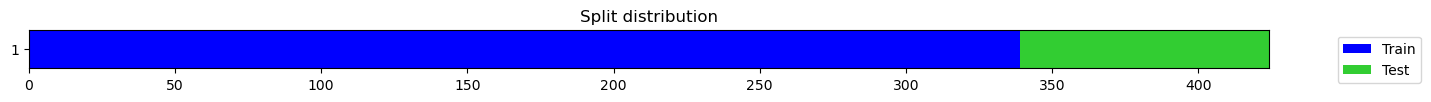

[5]  [ get_splits_ ] X~(424, 1, 17)
[5]  [ get_splits_ ] Train: 339 | Test 85
[5] [get_splits_ --> ]
[5]  [ fine_tune_mvp_single_ ] About to set callbacks
[5]  [ fine_tune_mvp_single_ ] About to set batch tfms
[5]  [ fine_tune_mvp_single_ ] Show plot


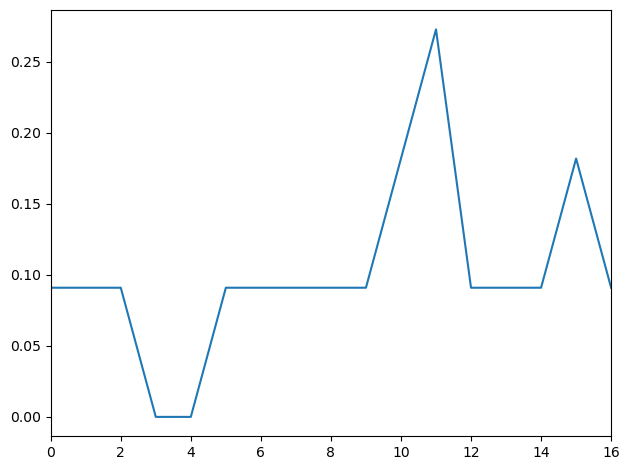

None

[5]  [ fine_tune_mvp_single_ ] Model Class <class 'fastai.learner.Learner'> | Type: <class 'fastai.learner.Learner'>
[5]  [ fine_tune_mvp_ ] Start timer
[5]  [ fine_tune_mvp_single_ ] Eval Pre | wlen 17 | Model: <class 'fastai.learner.Learner'> | <class 'fastai.learner.Learner'> 


best epoch:   0  val_loss: 0.996340 - pretrained weights_path='models/encoder_MVP.pth'
not enough values to plot a chart


best epoch:   0  val_loss: 0.971995 - pretrained weights_path='models/encoder_MVP.pth'
not enough values to plot a chart


best epoch:   0  val_loss: 0.906758 - pretrained weights_path='models/encoder_MVP.pth'
not enough values to plot a chart


best epoch:   0  val_loss: 0.928211 - pretrained weights_path='models/encoder_MVP.pth'
not enough values to plot a chart
[5]  [ fine_tune_mvp_ ] End timer -->
[5]  [ fine_tune_mvp_ ] Start: 1736961892.881772 | End: 1736961894.7537315 | Duration: 1.87 seconds
[5]  [ fine_tune_mvp_ ] Start timer
[5]  [ fine_tune_mvp_single_ ] Training the model | window size 17 | X ~ (424, 1, 17)


epoch,train_loss,valid_loss,time
0,0.920448,0.725718,00:00
1,0.755147,0.934929,00:00
2,0.642675,0.922317,00:00
3,0.570689,0.772215,00:00
4,0.538038,0.839564,00:00


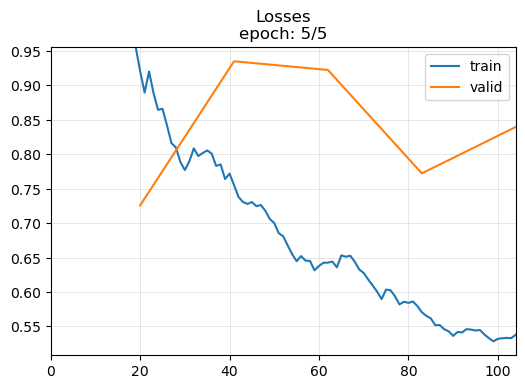


epochs: 5 best epoch:   0  val_loss: 0.725718 - pretrained weights_path='models/encoder_MVP.pth'



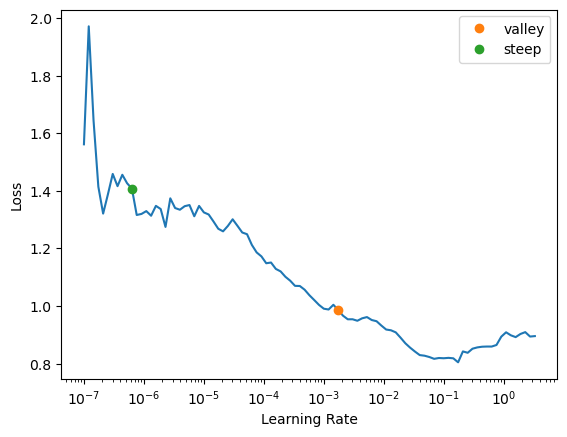

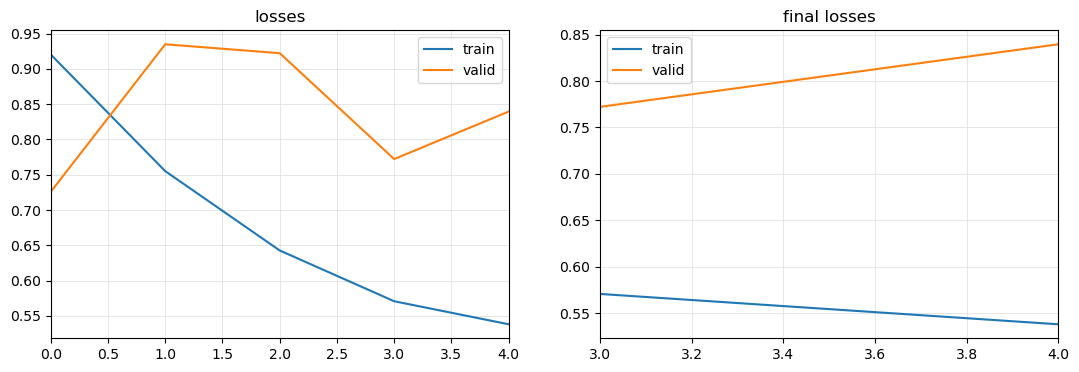

[5]  [ fine_tune_mvp_ ] End timer -->
[5]  [ fine_tune_mvp_ ] Start: 1736961894.756311 | End: 1736961904.188482 | Duration: 9.43 seconds
[5]  [ fine_tune_mvp_ ] Start timer
[5]  [ fine_tune_mvp_single_ ] Eval Pre | wlen 17


not enough values to plot a chart


not enough values to plot a chart


not enough values to plot a chart


not enough values to plot a chart
[5]  [ fine_tune_mvp_single_ ] Format results | results~4
[5]  [ fine_tune_mvp_ ] End timer -->
[5]  [ fine_tune_mvp_ ] Start: 1736961904.1915216 | End: 1736961904.618986 | Duration: 0.43 seconds
[5] [fine_tune_mvp_single_ --> ]
[5]  [ fine_tune_mvp_single_ ] Processing wlen 17
[5] [ --> fine_tune_mvp_single_ ]
[5] [ --> get_splits_ ]
[5]  [ get_splits_ ] len(X)=429
[5]  [ get_splits_ ] Online analysis


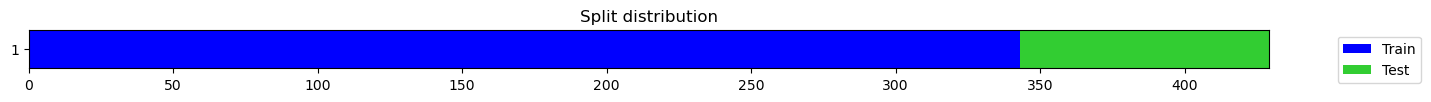

[5]  [ get_splits_ ] X~(429, 1, 12)
[5]  [ get_splits_ ] Train: 343 | Test 86
[5] [get_splits_ --> ]
[5]  [ fine_tune_mvp_single_ ] About to set callbacks
[5]  [ fine_tune_mvp_single_ ] About to set batch tfms
[5]  [ fine_tune_mvp_single_ ] Show plot


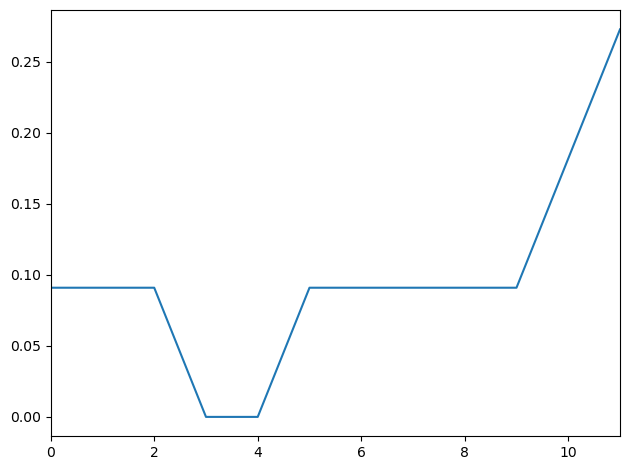

None

[5]  [ fine_tune_mvp_single_ ] Model Class <class 'fastai.learner.Learner'> | Type: <class 'fastai.learner.Learner'>
[5]  [ fine_tune_mvp_single_ ] Start timer
[5]  [ fine_tune_mvp_single_ ] Training the model | window size 12 | X ~ (429, 1, 12)


epoch,train_loss,valid_loss,time
0,0.819726,0.432736,00:00
1,0.664623,0.760579,00:00
2,0.584665,0.593278,00:00
3,0.527181,0.458981,00:00
4,0.478634,0.760456,00:00


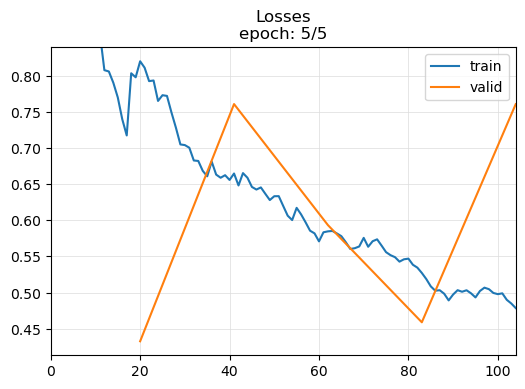


epochs: 5 best epoch:   0  val_loss: 0.432736 - pretrained weights_path='models/encoder_MVP.pth'



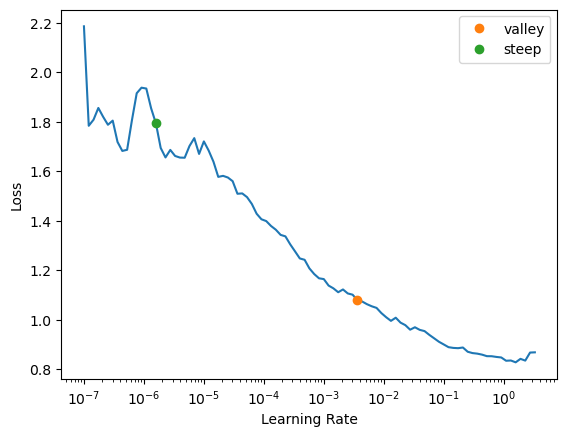

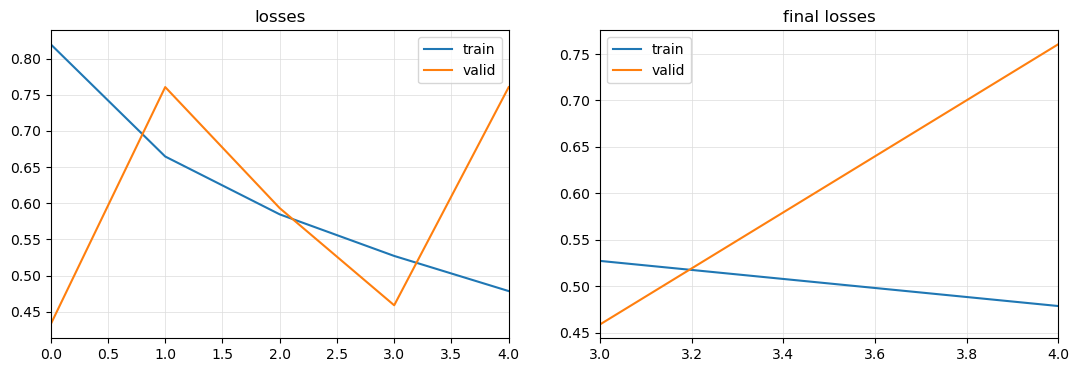

[5]  [ fine_tune_mvp_single_ ] End timer -->
[5]  [ fine_tune_mvp_single_ ] Start: 1736961905.7450452 | End: 1736961914.9264724 | Duration: 9.18 seconds
[5]  [ fine_tune_mvp_single_ ] Start timer
[5]  [ fine_tune_mvp_single_ ] Eval Pre | wlen 12


not enough values to plot a chart


not enough values to plot a chart


not enough values to plot a chart


not enough values to plot a chart
[5]  [ fine_tune_mvp_single_ ] Format results | results~4
[5]  [ fine_tune_mvp_single_ ] End timer -->
[5]  [ fine_tune_mvp_single_ ] Start: 1736961914.9316862 | End: 1736961915.3539295 | Duration: 0.42 seconds
[5] [fine_tune_mvp_single_ --> ]
[5]  [ fine_tune_mvp_single_ ] Processing wlen 17
[5] [ --> fine_tune_mvp_single_ ]
[5] [ --> get_splits_ ]
[5]  [ get_splits_ ] len(X)=423
[5]  [ get_splits_ ] Online analysis


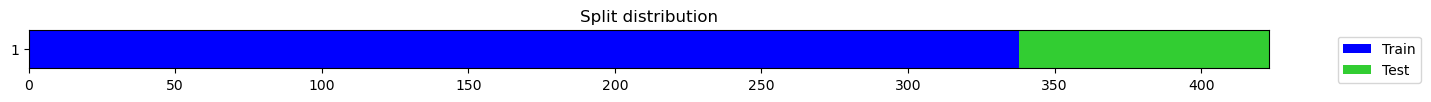

[5]  [ get_splits_ ] X~(423, 1, 18)
[5]  [ get_splits_ ] Train: 338 | Test 85
[5] [get_splits_ --> ]
[5]  [ fine_tune_mvp_single_ ] About to set callbacks
[5]  [ fine_tune_mvp_single_ ] About to set batch tfms
[5]  [ fine_tune_mvp_single_ ] Show plot


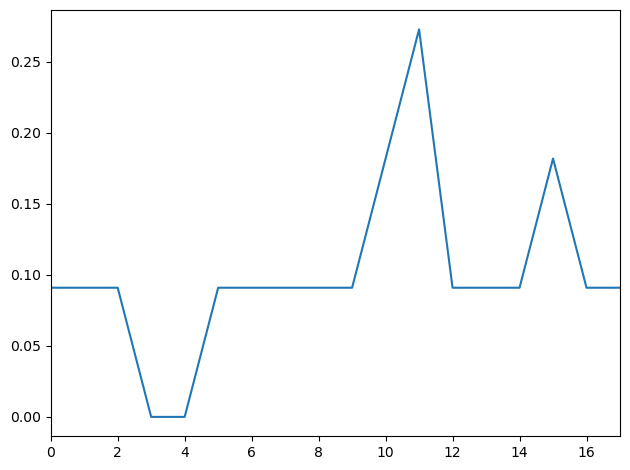

None

[5]  [ fine_tune_mvp_single_ ] Model Class <class 'fastai.learner.Learner'> | Type: <class 'fastai.learner.Learner'>
[5]  [ fine_tune_mvp_single_ ] Start timer
[5]  [ fine_tune_mvp_single_ ] Training the model | window size 18 | X ~ (423, 1, 18)


epoch,train_loss,valid_loss,time
0,0.921230,1.807740,00:00
1,0.741085,1.166505,00:00
2,0.662638,0.995132,00:00
3,0.597039,1.065818,00:00
4,0.539838,1.224481,00:00


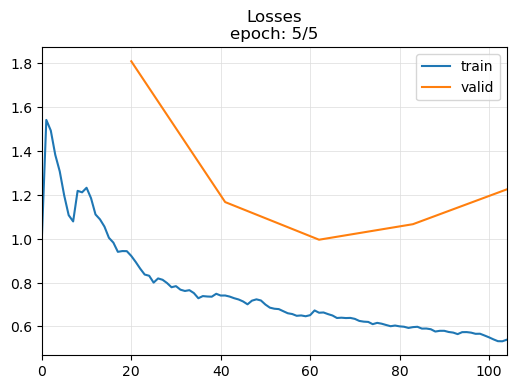


epochs: 5 best epoch:   2  val_loss: 0.995132 - pretrained weights_path='models/encoder_MVP.pth'



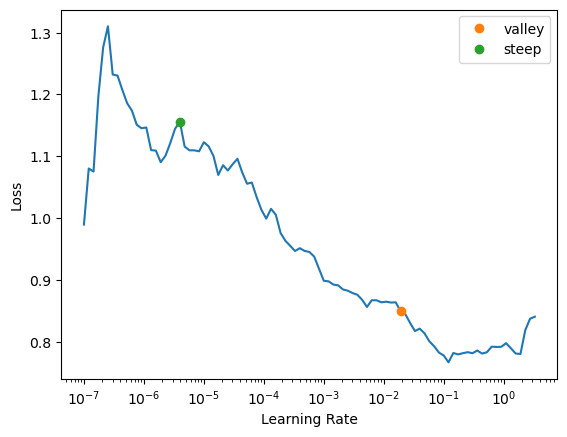

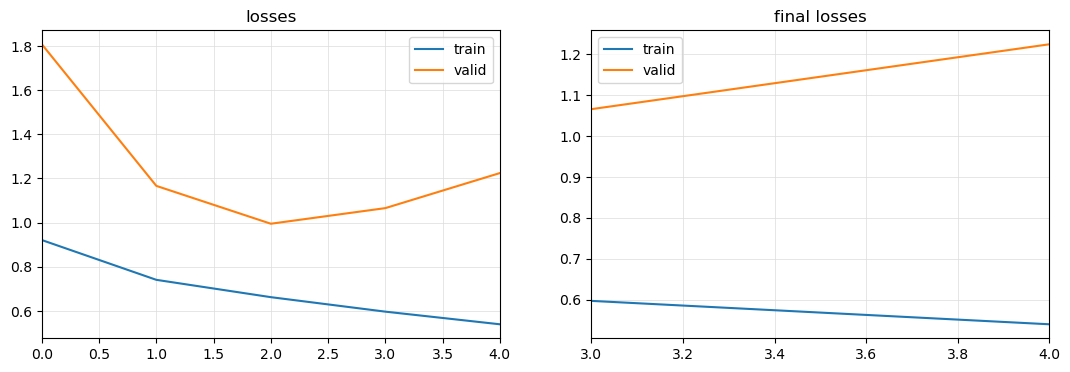

[5]  [ fine_tune_mvp_single_ ] End timer -->
[5]  [ fine_tune_mvp_single_ ] Start: 1736961915.9269595 | End: 1736961924.9669683 | Duration: 9.04 seconds
[5]  [ fine_tune_mvp_single_ ] Start timer
[5]  [ fine_tune_mvp_single_ ] Eval Pre | wlen 18


not enough values to plot a chart


not enough values to plot a chart


not enough values to plot a chart


not enough values to plot a chart
[5]  [ fine_tune_mvp_single_ ] Format results | results~4
[5]  [ fine_tune_mvp_single_ ] End timer -->
[5]  [ fine_tune_mvp_single_ ] Start: 1736961924.969963 | End: 1736961925.389195 | Duration: 0.42 seconds
[5] [fine_tune_mvp_single_ --> ]
[5] [fine_tune_mvp_ --> ]
[5] [fine_tune_mvp_ --> ]


In [28]:
result = fine_tune(
    X                             = df,
    enc_learn                     = enc_learner, 
    stride                        = 1,      
    batch_size                    = enc_run.config['batch_size'],
    cpu                           = config['cpu'], 
    to_numpy                      = False, 
    verbose                       = 5, 
    time_flag                     = True,
    n_windows                     = None,
    n_windows_percent             = 0.8, #Ventanas a tener en cuenta
    window_mask_percent           = enc_run.config['r'],
    training_percent              = 0.3, # Entreno con parte de los datos
    validation_percent            = 0.3, # Evalúo con parte de los datos
    num_epochs                    = 5,
    shot                          = True,
    eval_pre                      = True,
    eval_post                     = True,
    lr                            = enc_run.config['r'],
    #lr_scheduler_flag             = True, #Don't work in mvp
    lr_scheduler_flag             = False,
    #lr_scheduler_name             = "",
    lr_scheduler_num_warmup_steps = 1000,
    window_sizes                  = None,
    n_window_sizes                = 3,
    full_dataset                  = True,
    window_sizes_offset           = 0.05,
    windows_min_distance          = 5,
    print_to_path                 = False,
    print_path                    ="~/data/logs.txt",
    print_mode                    = 'w',
    use_moment_masks              = False,
    mask_stateful                 = enc_run.config['mask_stateful'],
    mask_future                   = enc_run.config['mask_future'],
    mask_sync                     = enc_run.config['mask_sync'],
    analysis_mode                 = enc_run.config['analysis_mode'],
    use_wandb                     = enc_run.config['use_wandb'],
    norm_by_sample                = enc_run.config['norm_by_sample'],
    norm_use_single_batch         = enc_run.config['norm_use_single_batch'],
    show_plot                     = True,
    metrics                       = [
                                         MSELossFlat, 
                                         RMSELossFlat, 
                                         SMAPELossFlat, 
                                         MAELossFlat
                                     ]
)

In [38]:
( 
    losses, 
    eval_results_pre, eval_results_post, 
    t_shots, t_shot, 
    t_evals, t_eval, model
) = result
print("Eval results pre:")
show_attrdict(eval_results_pre)
print("Eval results post:")
print(eval_results_post)
len(eval_results_post)
#show_attrdict(eval_results_post)

Eval results pre:
MSELossFlat: [0.9963403344154358]
RMSELossFlat: [0.9719945788383484]
SMAPELossFlat: [0.9067583680152893]
L1LossFlat: [0.9282109141349792]
Eval results post:
[{'MSELossFlat': [1.3044229745864868], 'RMSELossFlat': [1.179417371749878], 'SMAPELossFlat': [0.832288384437561], 'L1LossFlat': [1.3681817054748535]}, {'MSELossFlat': [1.0275429487228394], 'RMSELossFlat': [0.6624693274497986], 'SMAPELossFlat': [1.2046743631362915], 'L1LossFlat': [1.0031712055206299]}, {'MSELossFlat': [1.0751162767410278], 'RMSELossFlat': [0.9208686351776123], 'SMAPELossFlat': [1.3196885585784912], 'L1LossFlat': [1.0262173414230347]}]


3

In [30]:
embs = get_enc_embs_set_stride_set_batch_size(
    X          = enc_input, 
    enc_learn  = enc_learner, 
    stride     = enc_run.config['stride'],
    **get_embs_kwargs
)

[4] --> get_enc_embs_set_stride_set_batch_size
[4] get_enc_embs_set_stride_set_batch_size | MVP | True
[4] get_enc_embs_set_stride_set_batch_size | X ~(194, 1, 54)
[4] --> get_enc_embs_MVP_set_stride_set_batch_size
[4] [ Get Encoder Embeddings Ensure Batch Size ] Batch size proposed. Using 16
[4] get_enc_embs_MVP_set_stride_set_batch_size | Check CUDA | X ~ 97
[4] get_enc_embs_MVP_set_stride_set_batch_size | CUDA device id: 0
[4] get_enc_embs_MVP_set_stride_set_batch_size | CUDA device name: Quadro RTX 8000
[4] get_enc_embs_MVP_set_stride_set_batch_size | Ensure empty cache & move 2 GPU
[4] [ Get Encoder Embeddings Ensure Batch Size ] Batch size proposed. Using 16
[4] get_enc_embs_MVP_set_stride_set_batch_size | Set dataset from X (enc_learn does not contain dls)
[4] get_enc_embs_MVP_set_stride_set_batch_size | Get module
[4] get_enc_embs_MVP_set_stride_set_batch_size | Get acts and grads | aux_dl len 7
[4] get_enc_embs_MVP_set_stride_set_batch_size | Get acts and grads | aux_dl.batch_

In [31]:
embs.shape

(97, 128)

In [32]:
#enc_learner.task_name

In [33]:
timer.end()
timer.show()

38.88827705383301

In [34]:
#| export
if verbose > 0: print("Execution ended")
from dvats.imports import beep
beep(1)
beep(1)
beep(1)
beep(1)
beep(1)

In [35]:
#| hide
if reset_kernel:
    import os
    os._exit(00)